# Initialization

## Imports

In [ ]:
from collections import defaultdict
import gzip
# import math
# import string
import random

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# from sklearn import linear_model
# from sklearn import svm
# import scipy.optimize
import warnings
warnings.filterwarnings("ignore")

from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split

## Helper Functions

In [3]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        u,b,r = l.strip().split(',')
        r = int(r)
        yield u,b,r
def Jaccard(s1, s2):
    intersection = s1.intersection(s2)
    union = s1.union(s2)
    if not union:
        return 0
    return len(intersection) / len(union)

## Data Structures

In [4]:
answers = {}
allRatings = []
for l in readCSV("train_Interactions.csv.gz"):
    allRatings.append(l)
len(allRatings)

# Do an 8:1:1 split of data
ratingsTrain = allRatings[:190000]
ratingsValid = allRatings[190000:200000]

ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u,b,r in ratingsTrain:
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))

In [5]:
allRatings = []
userRatings = defaultdict(list)

for user,book,r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  userRatings[user].append(r)

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
  userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

# predictions = open("predictions_Rating.csv", 'w')
# for l in open("pairs_Rating.csv"):
#   if l.startswith("userID"):
#     #header
#     predictions.write(l)
#     continue
#   u,b = l.strip().split(',')
#   if u in userAverage:
#     predictions.write(u + ',' + b + ',' + str(userAverage[u]) + '\n')
#   else:
#     predictions.write(u + ',' + b + ',' + str(globalAverage) + '\n')

# predictions.close()

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("train_Interactions.csv.gz"):
  bookCount[book] += 1
  totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalRead/2: break

# predictions = open("predictions_Read.csv", 'w')
# for l in open("pairs_Read.csv"):
#   if l.startswith("userID"):
#     #header
#     predictions.write(l)
#     continue
#   u,b = l.strip().split(',')
#   if b in return1:
#     predictions.write(u + ',' + b + ",1\n")
#   else:
#     predictions.write(u + ',' + b + ",0\n")

# predictions.close()


In [ ]:
most_popular_avg_ratings = []
for i in range(0,len(mostPopular),3):
    curr_book = mostPopular[i][1]

    curr_book_ratings = [r for u,r in ratingsPerItem[curr_book]]
    n = len(curr_book_ratings)
    curr_book_avg_rating = sum(curr_book_ratings) / n if n else -1

    most_popular_avg_ratings.append((i,curr_book_avg_rating))

# create a scatterplot of most_popular_avg_ratings

x = [i for i,_ in most_popular_avg_ratings]
y = [r for _,r in most_popular_avg_ratings]

plt.scatter(x, y)
plt.show()

## Important Plots

In [ ]:
c = 0
grouped_ratings = []
curr_group_ratings = []

for i in range(0,len(mostPopular)):
    curr_book  = mostPopular[i][1]
    curr_book_ratings = [r for u,r in ratingsPerItem[curr_book]]

    curr_group_ratings = curr_group_ratings + curr_book_ratings

    c+=1
    if c > 100:
        group_rating = sum(curr_group_ratings) / len(curr_group_ratings) if len(curr_group_ratings) else -1
        grouped_ratings.append((i,group_rating))

        continue
    if i == len(mostPopular) - 1:
        group_rating = sum(curr_group_ratings) / len(curr_group_ratings) if len(curr_group_ratings) else -1

        grouped_ratings.append((i,group_rating))

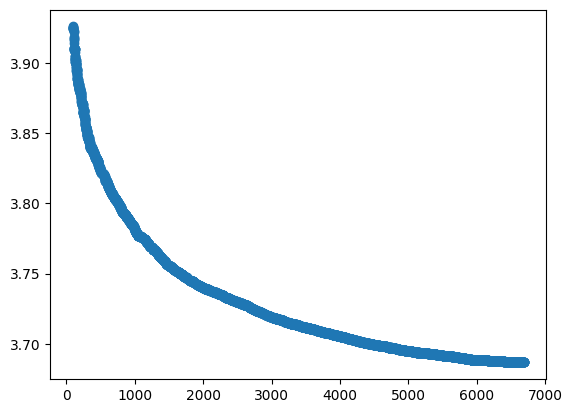

In [46]:
x = [i for i,_ in grouped_ratings]
y = [r for _,r in grouped_ratings]

plt.scatter(x, y)

# Modeling

## Dataset

In [96]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0, 5), skip_lines=1)

data = Dataset.load_from_file("train_Interactions.csv", reader=reader)

In [95]:
dataTrain, dataTest = train_test_split(data, test_size=0.1)

## Exploration

*using this code we can determine that the optimal value for n_factors should be 1*
`n_factors=1, mse=1.440318230709106`
`n_factors=2, mse=1.4406992901785303`
`n_factors=3, mse=1.441031335282106` ... `n_factors=100, mse=1.4826536828416017`

In [54]:
# n_factors = np.arange(1, 101, 1)
# for f in n_factors:
#     model = SVD(n_factors=f)
#     model.fit(dataTrain)
#     predictions = model.test(dataTest)

#     mse = 0
#     for p in predictions:
#         mse += (p.r_ui - p.est)**2
#     mse /= len(predictions)
#     print(f"n_factors={f}, mse={mse}")

*performing a grid search on `n_epochs`, the optimal rounds of training seems to be about ~29,30

In [77]:
def grid_search():
    print('bi,bu,pu,qi,mse')
    reg_params = [0.0001, 0.001, 0.01]
    for a in reg_params:
        for b in reg_params:
            for c in reg_params:
                for d in reg_params:

                    #EDIT THIS LINE FOR GRID SEARCH
                    #TODO change n_epochs to optimal
                    model = SVD(n_epochs=20, n_factors=2, reg_bi=a, reg_bu=b, reg_pu=c, reg_qi=d)

                    model.fit(dataTrain)
                    predictions = model.test(dataTest)

                    mse = sum([(p.r_ui - p.est)**2 for p in predictions]) / len(predictions)

                    print(f"factor={a,b,c,d}, mse={mse}")
grid_search()

bi,bu,pu,qi,mse
factor=(0.0001, 0.0001, 0.0001, 0.0001), mse=1.4422477028926945
factor=(0.0001, 0.0001, 0.0001, 0.001), mse=1.442746971242615
factor=(0.0001, 0.0001, 0.0001, 0.01), mse=1.442600900417679
factor=(0.0001, 0.0001, 0.001, 0.0001), mse=1.4416301148291784
factor=(0.0001, 0.0001, 0.001, 0.001), mse=1.4432959933265872
factor=(0.0001, 0.0001, 0.001, 0.01), mse=1.4419069747826823
factor=(0.0001, 0.0001, 0.01, 0.0001), mse=1.441993306248009
factor=(0.0001, 0.0001, 0.01, 0.001), mse=1.4417386771743361
factor=(0.0001, 0.0001, 0.01, 0.01), mse=1.4404376750517955
factor=(0.0001, 0.001, 0.0001, 0.0001), mse=1.444176569034843
factor=(0.0001, 0.001, 0.0001, 0.001), mse=1.4430760470621207
factor=(0.0001, 0.001, 0.0001, 0.01), mse=1.4405942608838231
factor=(0.0001, 0.001, 0.001, 0.0001), mse=1.4448441053713441
factor=(0.0001, 0.001, 0.001, 0.001), mse=1.4414672966801307
factor=(0.0001, 0.001, 0.001, 0.01), mse=1.440259242277601
factor=(0.0001, 0.001, 0.01, 0.0001), mse=1.4420862757703297
f

## Implementation

In [152]:
a,b,c,d = 0.0001, 0.001, 0.01, 0.01
model = SVD(n_factors=1, n_epochs=29, reg_bi=a, reg_bu=b, reg_pu=c, reg_qi=d)

In [153]:
model.fit(dataTrain)

In [154]:
predictions_test = model.test(dataTest)

In [155]:
# manually calculate the mse of the predictions
mse = 0
for p in predictions_test:
    mse += (p.r_ui - p.est)**2
mse /= len(predictions_test)
mse
# BASELINE ESTIMATION TO BEAT
#1.588636928376071	0.7141
# BEST CASE LEADERBOARD
# 1.417

1.389776980578083

In [156]:
predictions = open("predictions_Rating.csv", 'w')

for l in open("pairs_Rating.csv"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,b = l.strip().split(',')
  predictions.write(u + ',' + b + ',' + str(model.predict(u, b).est) + '\n')
predictions.close()

<Axes: >

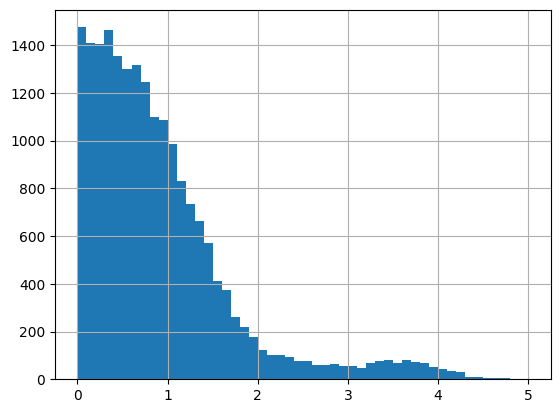

In [41]:
uid_outliars = []
bid_outliars = []
uid_inliars = []
bid_inliars = []

sses = []
for p in predictions:
    sse = np.abs(p.r_ui - p.est)
    if sse > 3:
        uid_outliars.append(p.uid)
        bid_outliars.append(p.iid)
    else:
        uid_inliars.append(p.uid)
        bid_inliars.append(p.iid)
    sses.append(sse)
pd.Series(sses).hist(bins=50)


(array([[ 82.,  65.,  41.,  34.,  33.,  24.,  26.,  22.,  25.,  21.,  11.,
          15.,  11.,   9.,   8.,   9.,  11.,  12.,   5.,  13.,  15.,   7.,
           8.,  11.,   5.,  10.,   3.,   7.,   6.,   5.,   7.,   3.,   8.,
           4.,   4.,   2.,   5.,   3.,   5.,   8.,   1.,   2.,   3.,   7.,
           2.,   5.,   4.,   0.,   2.,   1.],
        [216., 199., 174., 168., 165., 158., 159., 154., 156., 152., 143.,
         146., 136., 125., 126., 126., 131., 118., 108., 114., 117.,  93.,
          96.,  92.,  89.,  89.,  82.,  89.,  77.,  80.,  86.,  73.,  80.,
          70.,  76.,  75.,  64.,  67.,  73.,  57.,  52.,  56.,  51.,  51.,
          46.,  45.,  36.,  48.,  33.,  16.]]),
 array([   0.  ,  133.56,  267.12,  400.68,  534.24,  667.8 ,  801.36,
         934.92, 1068.48, 1202.04, 1335.6 , 1469.16, 1602.72, 1736.28,
        1869.84, 2003.4 , 2136.96, 2270.52, 2404.08, 2537.64, 2671.2 ,
        2804.76, 2938.32, 3071.88, 3205.44, 3339.  , 3472.56, 3606.12,
        3739.68, 3873.

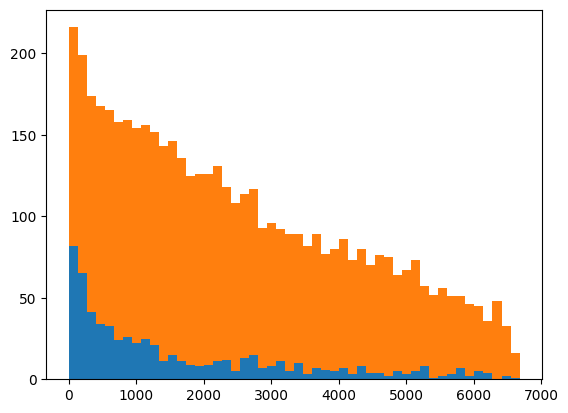

In [44]:
idx_outliars = []
idx_inliars = []
for i in range(len(mostPopular)):
    if mostPopular[i][1] in bid_outliars:
        idx_outliars.append(i)

    if mostPopular[i][1] in bid_inliars:
        idx_inliars.append(i)

# create a dual histogram of the indexes
plt.hist([idx_outliars, idx_inliars], bins=50, stacked=True)

# Bayesian Personalized Rating

In [93]:
import scipy
from implicit import bpr

In [105]:
userIDs,itemIDs = {},{}

for d in ratingsTrain:
    u,i = d[0],d[1]
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)

#Dataset in sparse matrix representation
Xui = scipy.sparse.lil_matrix((nUsers, nItems))
for d in ratingsTrain:
    Xui[userIDs[d[0]],itemIDs[d[1]]] = 1
Xui_csr = scipy.sparse.csr_matrix(Xui)

In [106]:
# Bayesian Personalized Ranking model with 5 latent factor
model = bpr.BayesianPersonalizedRanking(factors = 5)

model.fit(Xui_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
recommended = model.recommend(0, Xui_csr[0])
related = model.similar_items(0)
print(related)

# Extract user and item factors
itemFactors = model.item_factors
userFactors = model.user_factors
itemFactors[0]

(27914, 6683)

## Previous Model

In [221]:
import random

# Dataset containing all ratings
allRatings = []
for l in readCSV("train_Interactions.csv.gz"):
    allRatings.append(l)

#Train/Validation Sets
ratingsTrain = allRatings[:190000]
ratingsValid = allRatings[190000:]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u,b,r in ratingsTrain:
    ratingsPerUser[u].append((b,r))
    ratingsPerItem[b].append((u,r))

# Sets of unq. users/books
users, books = set(), set()

for u,b,r in allRatings:
    users.add(u)
    books.add(b)


# Dictionary containing number of ratings per book
bookCount = defaultdict(int) # Copied from baseline code
totalRead = 0

for user,book,_ in readCSV("train_Interactions.csv.gz"):
    bookCount[book] += 1
    totalRead += 1


# Validation set containing negative samples
true = [(u,b,1) for u,b,r in ratingsValid]
false = []
for u,b,r in ratingsValid:
    selection = books - {b[0] for b in ratingsPerUser[u]}
    b = random.choice(list(selection))

    false.append((u,b,0))

ratingsValid_q1 = true + false

In [225]:
len(true), len(false)

(10000, 10000)

In [222]:
threshold = int(0.7 * totalRead)

top_books = set()
count = 0
for item_count, item in mostPopular:
    count += item_count
    top_books.add(item)
    if count > threshold:
        break

# Calculate accuracy
curr_pred = [b in top_books for u, b, r in ratingsValid_q1]
accuracy = sum([x == y for x, y in zip(curr_pred, [1] * len(true) + [0] * len(false))]) / len(curr_pred)

print(f'Accuracy: {accuracy}')


Accuracy: 0.75255


In [ ]:
predictions, actuals = [], []

# All users who have read the book
for u, b, r in ratingsValid_q1[:10000]:
    users_b = set([u for u, _ in ratingsPerItem[b]])

    sims = []
    # Similarity between all books user has read and given book
    for b2, _ in ratingsPerUser[u]:
        users_b2 = set([user for user, _ in ratingsPerItem[b2]])

        curr_sim = Jaccard(users_b, users_b2)
        sims.append(curr_sim)

    if (sims and max(sims) >= 0.0001):
        prediction = 1
    elif b in top_books:
        prediction = 1
    else:
        prediction = 0
    predictions.append(prediction)

    actuals_t.append(r)

accuracy = accuracy_score(actuals, predictions)
accuracy

0.6825

In [238]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

predictions, actuals = [], []

# All users who have read the book
for u, b, r in ratingsValid_q1[10000:]:
    users_b = set([u for u, _ in ratingsPerItem[b]])

    sims = []
    # Similarity between all books user has read and given book
    for b2, _ in ratingsPerUser[u]:
        users_b2 = set([user for user, _ in ratingsPerItem[b2]])

        # Convert sets to binary vectors
        all_users = list(users_b.union(users_b2))
        vec1 = np.array([1 if user in users_b else 0 for user in all_users])
        vec2 = np.array([1 if user in users_b2 else 0 for user in all_users])

        curr_sim = cosine_similarity([vec1], [vec2])[0][0]
        sims.append(curr_sim)

    if (sims and max(sims) >= 0.0001):
        prediction = 1
    elif b in top_books:
        prediction = 1
    else:
        prediction = 0
    predictions.append(prediction)

    actuals.append(r)

accuracy = accuracy_score(actuals, predictions)
accuracy

0.5375

In [245]:
u,b,r = ratingsValid_q1[0]
print(u,b,r)
users_b = set([u for u, _ in ratingsPerItem[b]])
len(users_b)

u47877739 b50020691 1


39

In [158]:
predictions = open("predictions_Read.csv", 'w')
for l in open("pairs_Read.csv"):
  if l.startswith("userID"):
    # header
    predictions.write(l)
    continue
  u, b = l.strip().split(',')
  users_b = set([user for user, _ in ratingsPerItem[b]])
  
  sims = []
  for b2, _ in ratingsPerUser[u]:
    users_b2 = set([user for user, _ in ratingsPerItem[b2]])
    curr_sim = Jaccard(users_b, users_b2)
    sims.append(curr_sim)
  
  if sims and max(sims) >= 0.0001:
    predictions.write(u + ',' + b + ",1\n")
  else:
    predictions.write(u + ',' + b + ",0\n")

predictions.close()


In [253]:
book_popularity = {}
for u, b, _ in ratingsTrain:
    book_popularity[b] = book_popularity.get(b, 0) + 1

sorted_books = sorted(book_popularity.items(), key=lambda x: x[1], reverse=True)
threshold_index = int(len(sorted_books) * 0.3)
popular_books = set([b for b, _ in sorted_books[:threshold_index]])

user_ids = {u: idx for idx, u in enumerate(set(u for u, _, _ in ratingsTrain))}
book_ids = {b: idx for idx, b in enumerate(set(b for _, b, _ in ratingsTrain))}

import scipy.sparse as sp

rows = []
cols = []
for u, b, _ in ratingsTrain:
    rows.append(book_ids[b])
    cols.append(user_ids[u])

data = [1] * len(rows)
book_user_matrix = sp.csr_matrix((data, (rows, cols)), shape=(len(book_ids), len(user_ids)))


from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between books
book_similarity = cosine_similarity(book_user_matrix)


def predict_user_has_read_book(u, b, similarity_threshold=0.1):
    # Check if book is popular
    if b in popular_books:
        return True

    # If user hasn't read any books, cannot compute similarity
    if u not in ratingsPerUser:
        return False

    # Get indices
    if b not in book_ids:
        return False  # Book not in training data
    b_idx = book_ids[b]

    # Get indices of books the user has read
    user_books = [book_ids[b_read] for b_read, _ in ratingsPerUser[u] if b_read in book_ids]

    if not user_books:
        return False

    # Compute similarities
    similarities = book_similarity[b_idx, user_books]
    max_similarity = similarities.max()

    # Prediction based on similarity threshold
    return max_similarity >= similarity_threshold

predictions = []
actuals = []
for u, b, r in ratingsValid_q1:
    pred = predict_user_has_read_book(u, b)
    predictions.append(pred)
    actuals.append(r)

from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions)
recall = recall_score(actuals, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Accuracy: 0.74115
Precision: 0.7214213570838307
Recall: 0.7857


In [254]:
predictions

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True

In [ ]:
# create a plot that 

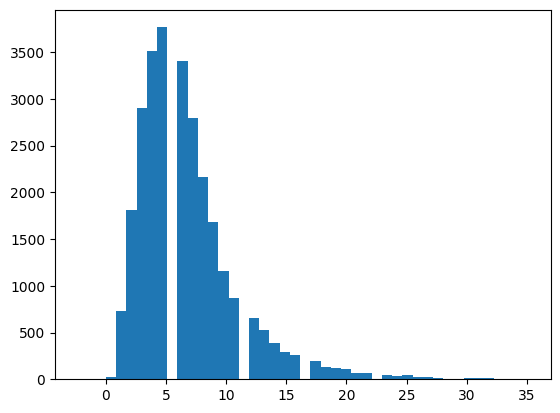

In [265]:
ratings_b = []
for b in ratingsPerItem.keys():
    ratings_b.append(len(ratingsPerItem[b]))
ratings_u = []
for u in ratingsPerUser.keys():
    ratings_u.append(len(ratingsPerUser[u]))

# generate histogram to view distribution of number of ratings
plt.hist(ratings_u, bins=100)
plt.xlim(right=37)
plt.show()


In [255]:
# Example: Calculate accuracy for popular books vs. less popular books
popular_book_ids = popular_books  # From previous calculations
predictions_popular = []
actuals_popular = []
predictions_unpopular = []
actuals_unpopular = []

for idx, (u, b, r) in enumerate(ratingsValid_q1):
    if b in popular_book_ids:
        predictions_popular.append(predictions[idx])
        actuals_popular.append(actuals[idx])
    else:
        predictions_unpopular.append(predictions[idx])
        actuals_unpopular.append(actuals[idx])

# Compute metrics
accuracy_popular = accuracy_score(actuals_popular, predictions_popular)
accuracy_unpopular = accuracy_score(actuals_unpopular, predictions_unpopular)

print(f'Accuracy on popular books: {accuracy_popular}')
print(f'Accuracy on less popular books: {accuracy_unpopular}')


Accuracy on popular books: 0.7231994075171264
Accuracy on less popular books: 0.7622309197651663


In [248]:
# Write model predictions to predictions_Read.csv
predictions = open("predictions_Read.csv", 'w')
for l in open("pairs_Read.csv"):
    if l.startswith("userID"):
        # header
        predictions.write(l)
        continue
    u, b = l.strip().split(',')
    pred = predict_user_has_read_book(u, b)
    predictions.write(u + ',' + b + ',' + str(int(pred)) + '\n')